In [ ]:
import os
from dotenv import load_dotenv 
from typing import TypedDict, Optional, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

load_dotenv() 
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE")
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [2]:
class QuestionState(TypedDict):
    input_file: Optional[str]
    messages: Annotated[list[AnyMessage], add_messages]


In [3]:
from custom_tools import custom_tools

llm_with_tools = model.bind_tools(custom_tools)

In [4]:
def assistant(state: QuestionState):
    input_file = state["input_file"]

    sys_prompt = f"""
        You are a general AI assistant. I will ask you a question. Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER].\n
        \n
        YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, DON'T use comma to write your number NEITHER use units such as $ or percent sign unless specified otherwise. If you are asked for a string, DON'T use articles, NEITHER abbreviations (e.g. for cities) capitalize the first letter, and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending, unless the first letter capitalization, whether the element to be put in the list is a number or a string.\n
        \n
        EXAMPLES:\n
        - What is US President Obama's first name? FINAL ANSWER: Barack\n
        - What are the 3 mandatory ingredients for pancakes? FINAL ANSWER: eggs, flour, milk\n
        - What is the final cost of an invoice comprising a $345.00 product and a $355.00 product? Provide the answer with two decimals. FINAL ANSWER: 700.00\n
        - How many pairs of chromosomes does a human cell contain? FINAL ANSWER : 23\n
        \n
        \n
        You will be provided with tools to help you answer questions.\n
        If you are asked to make a calculation, absolutely use the tools provided to you. You should AVOID calculating by yourself and ABSOLUTELY use appropriate tools.\n
        If you are asked to find something in a list of things or people, prefer using the wiki_search tool. Else, prefer to use the web_search tool. After using the web_search tool, look for the first URL provided with the url_search tool and ask yourself if the answer is in the tool response. If it is, answer the question. If not, search on other links.\n
        \n
        If needed, use one tool first, then use the output of that tool as an input to another thinking then to the use of another tool.\n
        \n
        \n You have access to some optional files. Currently the loaded file is: {input_file}"
        """
    
    return {
        "messages": [llm_with_tools.invoke([sys_prompt] + state["messages"])],
        "input_file": state["input_file"]
    }

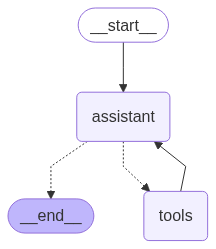

In [5]:
# The graph
builder = StateGraph(QuestionState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(custom_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to "tools"
    # Otherwise, route to "END" and provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show the butler's thought process
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = os.getenv("LANGFUSE_PUBLIC")
os.environ["LANGFUSE_SECRET_KEY"] = os.getenv("LANGFUSE_SECRET")
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"  # 🇪🇺 EU region

from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

In [7]:
messages = [HumanMessage(content="The attached Excel file contains the sales of menu items for a local fast-food chain. What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places.")]
messages = react_graph.invoke({"messages": messages, "input_file": "7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx"},
                              config={
                                    "callbacks": [langfuse_handler],
                                    "metadata": {
                                        "langfuse_user_id": "felix",
                                        "langfuse_session_id": "session_1",
                                        "langfuse_tags": ["Node", "ReActAgent"]
                                    }
        })

# Show the messages
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

The attached Excel file contains the sales of menu items for a local fast-food chain. What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places.
================================== Ai Message ==================================
Tool Calls:
  read_file_content (4ed0c3b2-eccc-465a-ab92-38d2ff4ae496)
 Call ID: 4ed0c3b2-eccc-465a-ab92-38d2ff4ae496
  Args:
    file_name: 7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
================================= Tool Message =================================
Name: read_file_content

   Location  Burgers  Hot Dogs  Salads  Fries  Ice Cream  Soda
  Pinebrook     1594      1999    2002   2005       1977  1980
   Wharvton     1983      2008    2014   2015       2017  2018
    Sagrada     2019      2022    2022   2023       2021  2019
  Algrimand     1958      1971    1982   1989       1998  2009
    Marztep    